In [3]:
import pandas as pd
from tensorflow.keras import layers, models, optimizers
from keras.models import Sequential
from tensorflow.keras.layers import Dropout
from keras.layers import LSTM, Dense,Flatten
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from os.path import exists

In [4]:
#df=pd.read_csv("https://raw.githubusercontent.com/YBI-Foundation/Dataset/main/Airline%20Delay.csv")
#df.to_csv("AirlineDelay.csv")
df=pd.read_csv("AirlineDelay.csv")

df.dropna(inplace=True,axis=0)

#print(sum(df['arr_delay'].values))
#mean = sum(df['arr_delay'].values) / len(df['arr_delay'].values)
#std_dev = (sum([(x - mean) ** 2 for x in df['arr_delay']]) / len(df['arr_delay'])) ** 0.5
#print(mean,std_dev)


In [5]:
 df=df[df["arr_cancelled"]==0]

arrivingFlights=df['arr_flights']
df['carrier_ct']=df['carrier_ct']/df['arr_flights']
df['weather_ct']=df['weather_ct']/df['arr_flights']
df['nas_ct']=df['nas_ct']/df['arr_flights']
df['security_ct']=df['security_ct']/df['arr_flights']
df['late_aircraft_ct']=df['late_aircraft_ct']/df['arr_flights']
df['carrier_delay']= df['carrier_delay']/df['arr_flights']
df['weather_delay']=df['weather_delay']/df['arr_flights']
df['security_delay']= df['security_delay']/df['arr_flights']
df['late_aircraft_delay']=df['late_aircraft_delay']/df['arr_flights']
df['arr_delay']=df['arr_delay']/df['arr_flights']

std=df['arr_delay'].std()
mean=df['arr_delay'].mean()
threshhold=mean+2*std
filter=((df['arr_delay']<threshhold))

df=df[filter]


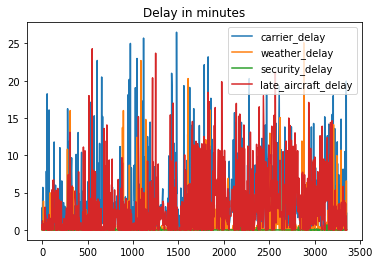

In [6]:
df['carrier_delay'].plot(legend="Carrier")
df['weather_delay'].plot(legend="Weather")
df['security_delay'].plot(legend="Security")
df['late_aircraft_delay'].plot(legend="Late")
plt.title("Delay in minutes")
plt.legend()
plt.show()

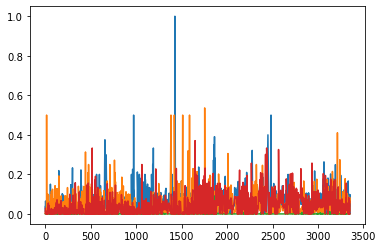

In [7]:
df['carrier_ct'].plot()
df['nas_ct'].plot()
df['security_ct'].plot()
df['late_aircraft_ct'].plot()
plt.show()

<AxesSubplot:>

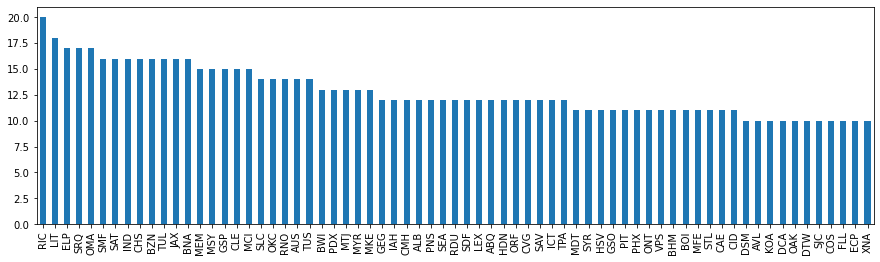

In [8]:
fig, ax = plt.subplots(figsize=(15,4))
flights=df[df.groupby("airport")['airport'].transform('size') > 9]["airport"]
#print(flights)

flights.value_counts().plot(kind="bar",ax=ax)
#plt.xticks(rotation=90)
#plt.title("Airport Flights")
#plt.show()

delay mean: 8.18461880049377 28.467741935483872
late_aircraft_delay mean: 0.0 0
carrier_delay mean: 0.0 0


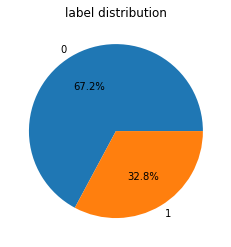

In [12]:
encoder=LabelEncoder()
df['carrier']=encoder.fit_transform(df['carrier'])
df['airport']=encoder.fit_transform(df['airport'])
if "airport_name" in df.columns:
    df.drop(["arr_del15","arr_cancelled","year", "airport_name","carrier_name","nas_delay",],axis=1,inplace=True)

def arr_delay_columns(row):
    #if row['arr_delay'] > 0 or row['late_aircraft_delay'] > 0:
    if row['arr_delay'] > 10 :
        return 1
    else:
        return 0

df['label'] = df.apply(arr_delay_columns, axis=1)

def late_aircraft_delay_columns(row):
    if row['late_aircraft_delay'] > 10 :
        return 1
    else:
        return 0

def carrier_delay_columns(row):
    if row['carrier_delay'] > 10 :
        return 1
    else:
        return 0

    

print("delay mean:",df['arr_delay'].mean(),df['arr_delay'].max())
print("late_aircraft_delay mean:",df['late_aircraft_delay'].mean(),df['late_aircraft_delay'].max())
print("carrier_delay mean:",df['carrier_delay'].mean(),df['carrier_delay'].max())

df['late_aircraft_delay'] = df.apply(late_aircraft_delay_columns, axis=1)
df['carrier_delay'] = df.apply(carrier_delay_columns, axis=1)

counts = df["label"].value_counts()
total = df["label"].count()
# get the percentage of each value
percents = counts / total
# plot the pie chart
plt.pie(percents, labels=percents.index, autopct='%1.1f%%')
plt.title('{} distribution'.format("label"))
plt.show()

#df['label'].plot()

In [64]:


X_columns=[x for x in df.columns if not x in['label','arr_delay']]

X=df[X_columns]
y=df['label']

print(X_columns)

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)


#print(X)

['Unnamed: 0', 'month', 'carrier', 'airport', 'arr_flights', 'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct', 'arr_diverted', 'carrier_delay', 'weather_delay', 'security_delay', 'late_aircraft_delay']


In [68]:
lookback=6
#lookahead=1
n_features=len(X_columns)
#print(n_features)
#model.add(LSTM(units=100, activation='tanh', return_sequences=True, input_shape=(look_back, features),dtype="float32"))
#model.add(Dropout(0.2))
#model.add(LSTM(units = 50, activation='tanh', return_sequences = True))
#model.add(LSTM(units = 50))
#model.add(Flatten())
#model.add(Dense(len(y_train.columns),activation='softmax'))
#model.compile(optimizer="rmsprop", loss='categorical_crossentropy', metrics=['accuracy'])

inputs = layers.Input((lookback, n_features),dtype="float32")
lstm1 = layers.LSTM(200, activation='tanh', return_sequences=True)
#batch1=layers.BatchNormalization()
#dropout1 = layers.Dropout(0.025)
lstm2 = layers.LSTM(200, activation='tanh', return_sequences=False)
batch2=layers.BatchNormalization()

dense1 = layers.Dense(200)
dropout1 = layers.Dropout(0.025)
dense2 = layers.Dense(100)

#dense2 = layers.Dense(50)
output = layers.Dense(1,activation="sigmoid")
#output = layers.Dense(lookahead * 2)
#reshape = layers.Reshape((lookahead, 2))

out = lstm1(inputs)
#out= batch1(out)
out = lstm2(out)
out= batch2(out)
#out = dropout2(out)
#out = lstm3(out)
out = dense1(out)
out = dropout1(out)
out = dense2(out)
#out = flatten(out)
#out = dense2(out)
outputs = output(out)
#outputs = reshape(outputs)

In [69]:
model = models.Model(inputs, outputs)

optimizer = optimizers.Adam()
model.compile(
    #optimizer="rmsprop", 
    optimizer=optimizer,
    loss='binary_crossentropy',
    #loss=MeanSquaredError(reduction="auto", name="mean_squared_error"),
    weighted_metrics=["acc"],
)

model.summary()

es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=20)

X2_train = np.asarray(X_train).astype(np.float32)
X2_train = np.resize(X2_train,(X2_train.shape[0],lookback,X2_train.shape[1]))
y2_train = np.asarray(y_train).astype(np.float32)

X2_test = np.asarray(X_test).astype(np.float32)
X2_test = np.resize(X2_test,(X2_test.shape[0],lookback,X2_test.shape[1]))
y2_test = np.asarray(y_test).astype(np.float32)

path_to_file="C:\\Users\\dnishimoto\\python_files\\python-deep-learning-master\\lstm_flight_delay.h5"
file_exists = exists(path_to_file)
if(file_exists):
    model.load_weights(path_to_file)

# Fit data
history = model.fit(
    X2_train,
    y2_train,
    epochs=200,
    validation_data=(X2_test, y2_test),
    # verbose=0,
    shuffle=False,
    #callbacks=[es],
)

model.save_weights(path_to_file) 



Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 6, 15)]           0         
                                                                 
 lstm_6 (LSTM)               (None, 6, 200)            172800    
                                                                 
 lstm_7 (LSTM)               (None, 200)               320800    
                                                                 
 batch_normalization_3 (Batc  (None, 200)              800       
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 200)               40200     
                                                                 
 dropout_3 (Dropout)         (None, 200)               0         
                                                           

34/34 [==============================] - 1s 24ms/step - loss: 0.3329 - acc: 0.8484 - val_loss: 1.1431 - val_acc: 0.6585
Epoch 52/200
34/34 [==============================] - 1s 27ms/step - loss: 0.3469 - acc: 0.8409 - val_loss: 1.4564 - val_acc: 0.6962
Epoch 53/200
34/34 [==============================] - 1s 26ms/step - loss: 0.3330 - acc: 0.8474 - val_loss: 1.2082 - val_acc: 0.6925
Epoch 54/200
34/34 [==============================] - 1s 26ms/step - loss: 0.3085 - acc: 0.8540 - val_loss: 1.6106 - val_acc: 0.3868
Epoch 55/200
34/34 [==============================] - 1s 25ms/step - loss: 0.3588 - acc: 0.8372 - val_loss: 1.4632 - val_acc: 0.4132
Epoch 56/200
34/34 [==============================] - 1s 25ms/step - loss: 0.3616 - acc: 0.8316 - val_loss: 1.3713 - val_acc: 0.7075
Epoch 57/200
34/34 [==============================] - 1s 28ms/step - loss: 0.3332 - acc: 0.8474 - val_loss: 1.0804 - val_acc: 0.6509
Epoch 58/200
34/34 [==============================] - 1s 25ms/step - loss: 0.2931 

34/34 [==============================] - 1s 27ms/step - loss: 0.1471 - acc: 0.9340 - val_loss: 2.3071 - val_acc: 0.7075
Epoch 174/200
34/34 [==============================] - 1s 27ms/step - loss: 0.1732 - acc: 0.9284 - val_loss: 1.9297 - val_acc: 0.6736
Epoch 175/200
34/34 [==============================] - 1s 28ms/step - loss: 0.1170 - acc: 0.9488 - val_loss: 2.5194 - val_acc: 0.6811
Epoch 176/200
34/34 [==============================] - 1s 27ms/step - loss: 0.1184 - acc: 0.9563 - val_loss: 2.6840 - val_acc: 0.7038
Epoch 177/200
34/34 [==============================] - 1s 29ms/step - loss: 0.1536 - acc: 0.9293 - val_loss: 2.1748 - val_acc: 0.6774
Epoch 178/200
34/34 [==============================] - 1s 27ms/step - loss: 0.1410 - acc: 0.9460 - val_loss: 1.8875 - val_acc: 0.6245
Epoch 179/200
34/34 [==============================] - 1s 26ms/step - loss: 0.1543 - acc: 0.9377 - val_loss: 3.0131 - val_acc: 0.6849
Epoch 180/200
34/34 [==============================] - 1s 27ms/step - loss: 

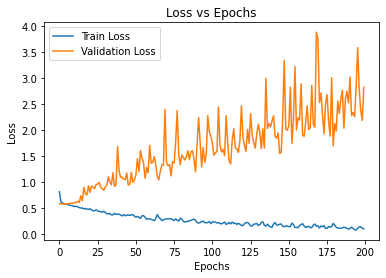

In [77]:
# Plot loss
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [78]:

y_pred=model.predict(X2_train)
y_pred=[float(x) if x>0.5 else 0 for x in y_pred ]
#plt.plot(y_pred,c="blue",alpha=0.6)
#print(pred_y)
#plt.plot(y2_train,c="red",alpha=0.3)
#plt.show()

34/34 [==============================] - 1s 9ms/step


1


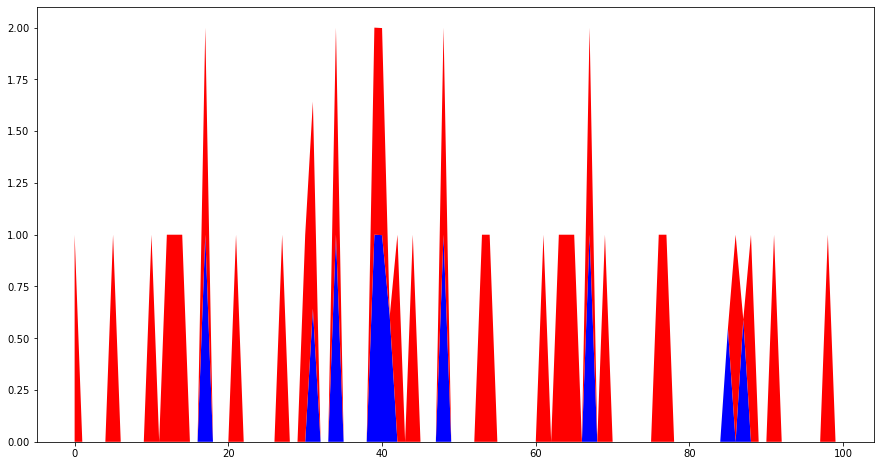

In [79]:
fig, ax = plt.subplots(figsize=(15,8))
legend_labels=["Prediction","Train"]
colors=["Blue","Red"]
#units=np.arange(0,len(y_pred))
units=np.arange(0,100)
#print(len(units),y_pred,len(y_train))
ax.stackplot(units,y_pred[0:100], [1 if y>0.5 else 0 for y in y_train][0:100], labels=legend_labels, colors=colors)   
print(np.max(y_train))

In [80]:
def accuracy(predictions, labels):
    correct=0
    for index,x in enumerate(predictions):
        if predictions[index] == labels[index]:
            correct+=1
    return (100.0 * correct
            / len(predictions))


In [81]:
print("accuracy: ",accuracy(y_pred[0:100], [1 if y>0.5 else 0 for y in y_train][0:100]))

accuracy:  70.0
